<a href="https://colab.research.google.com/github/hchang18/non-parametric-methods/blob/main/kernel_regression_estimator_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### STAT 580 Non parametric methods (Spring 2021) 

### midterm exam
Haeyoon Chang

1. Repeat your estimation 1000 times, each time you need to re-generate your data. Compute the mean of the 1000 estimation $\hat f(x)$, that should be very close to the truth. Remember selecting bandwidth properly.  

2. Generate a 95% empirical confidence band of $\hat f(x)$

    **Approach for problems 1 and 2:**
    - generate data 
    - estimate optimal bandwidth (just once for computation efficiency)
    - estimate $\hat f(x)$ 
    - save $\hat f(x)$ for each $x$ (120 $x$'s and for each $x$, there are 1000 $\hat f(x)$)
    - calculate mean of $\hat f(x)$ for each $x$
    - calculate 2.5% and 97.5% percentiles of 1000  $\hat f(x)$


In [69]:
# import libraries
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
from scipy.stats import norm, expon

from random import seed
from random import randrange, uniform

sns.set(color_codes=True)
plt.rcParams["figure.figsize"] = (20,15)

In [70]:
# ===================================================
# Generate data                                     |
# ===================================================
def generate_data(n):
    x = list()
    y = list()

    for i in range(n):
        rand_x = uniform(-2, 10)
        x.append(rand_x)
        if rand_x < 1:
            rand_y = (rand_x ** 2) / 20
        elif 1 <= rand_x < 4:
            rand_y = rand_x / 10 - 1 / 20
        else:
            rand_y = rand_x * np.sin(rand_x - 2.4) / 16 - 0.5 + 7 / 20
    
        eta = np.random.normal(0, 0.2)
        y.append(rand_y + eta)
        
    x = np.array(x).reshape(n, 1)
    y = np.array(y).reshape(n, 1)
    data = np.hstack((np.array(y), np.array(x)))

    return data, y, x

In [71]:
# ============================================
# Kernel Regression Estimator                |
# ============================================
def kernel_regression_estimator(data, kernel_func, bandwidth):
    """ Generate kernel regression estimator over data."""
    X = data[:, 1]
    Y = data[:, 0]
    kernels = dict()
    n = len(X)
    for d in X:
        kernels[d] = kernel_func(d, bandwidth)
    def evaluate(x):
        """Evaluate `x` using kernels above."""
        resp = list()
        weight = list()
        for d in X:
            resp.append(kernels[d](x))
        resp_sum = sum(resp) # denominator
        for i in range(n):
            weight.append(resp[i]/resp_sum)
        result = list()
        for i in range(n):
            result.append(weight[i]*Y[i])
        return sum(result)
    return (evaluate)

In [72]:
# ============================================
# Gaussian Kernel PDF                        |
# ============================================
def gaussian_pdf(x_i, bandwidth):
    """Return Gaussian kernel density estimator."""
    x_bar  = x_i
    def evaluate(x):
        """Evaluate x."""
        pdf = (np.sqrt(2*np.pi*bandwidth**2)**-1) * np.exp(-((x - x_bar)**2)/(2*bandwidth**2))
        return(pdf)
    return(evaluate)

In [73]:
# https://machinelearningmastery.com/implement-resampling-methods-scratch-python/
def split_into_folds(dataset, folds=10):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset)/folds)
    for i in range(folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split

def split_test_train_set(dataset, k, test_idx):
    folds = split_into_folds(dataset, folds=k)
    test = np.array(folds[test_idx])
    
    train = list()
    for i, x in enumerate(folds):
        if i != test_idx:
            train.extend(folds[i])
    train = np.array(train)
    return test, train

In [74]:
def estimate_bandwidth(data, kernel_function):
    num_samples = len(data[:, 0])
    y = data[:, 0]
    x = data[:, 1]
    # list of bandwidth 
    bandwidths = np.arange(0.01, 2, 0.02)

    # estimate y_hat corresponding to X
    errors = list()
    k = 10
    for h in bandwidths:
        error = 0
        folds = split_into_folds(data, k)
        for i in range(k):
            test, train = split_test_train_set(data, k, i)
            estimator = kernel_regression_estimator(train, kernel_func=kernel_function, bandwidth=h)
            y_hat = [estimator(x) for x in test[:, 1]]
            error += (test[:, 0] - y_hat)**2
        errors.append(sum(error))

    errors = np.array(errors)
    h_opt = bandwidths[np.argmin(errors)]
    return h_opt                                                                                                        

In [75]:
# repeat the estimation 1000 times
f_hat_list = []

for i in range(1000):
    # generate data
    n = 200
    data, _ , _ = generate_data(n)
    xi = data[:, 1]
    x = np.arange(-2, 10, .1)
    # estimate bandwidth - calculate on the first dataset
    if i == 0:
        h_cv = estimate_bandwidth(data, gaussian_pdf)
        print(h_cv)
    # estimate f_hat 
    estimator = kernel_regression_estimator(data, gaussian_pdf, bandwidth=h_cv)
    y_hat = [estimator(i) for i in x]

    f_hat_list.append(y_hat)

0.16999999999999998


In [76]:
# Compute the mean of 1000 estimation f_hat
f_hat_arr = np.array(f_hat_list)
mean = f_hat_arr.mean(axis=0)
lower_bound = np.percentile(f_hat_arr, 2.5, axis=0)
upper_bound = np.percentile(f_hat_arr, 97.5, axis=0)

In [77]:
# true function graph 
def true_function():
    y_list = list()
    x_arr = np.arange(-2, 10, .1)
    n = len(x_arr)

    for x in x_arr:
        if x < 1:
            y = (x ** 2) / 20
        elif 1 <= x < 4:
            y = x / 10 - 1 / 20
        else:
            y = x * np.sin(x - 2.4) / 16 - 0.5 + 7 / 20
    
        # eta = np.random.normal(0, 0.2)
        y_list.append(y)
        
    x = x_arr.reshape(n, 1)
    y = np.array(y_list).reshape(n, 1)
    data = np.hstack((np.array(y), np.array(x)))

    return data, y, x

In [78]:
_, true_y, _ = true_function()

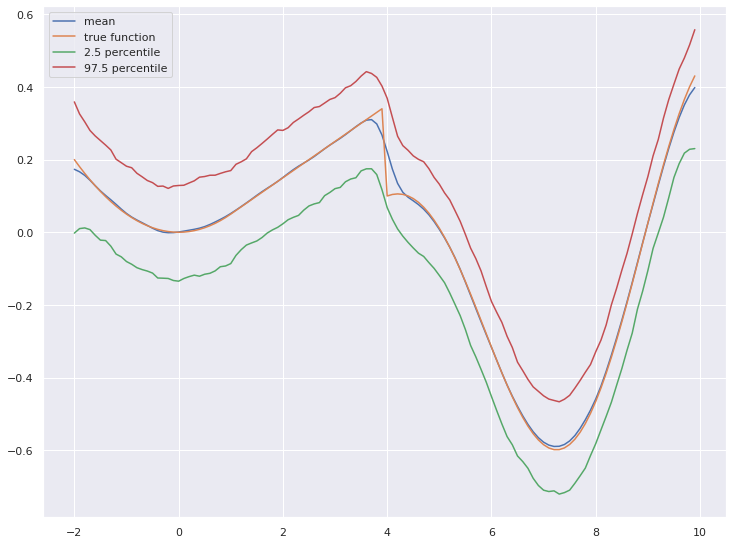

In [84]:
# plot of mean, bottom 2.5 percent, upper 2.5 percent, and true function 
fig = plt.figure()
ax = fig.add_subplot(2, 2, 1)
g = ax.grid(True)
ax.plot(x, mean, label='mean')
ax.plot(x, true_y, label='true function')
ax.plot(x, lower_bound, label='2.5 percentile')
ax.plot(x, upper_bound, label='97.5 percentile')
leg = ax.legend()
plt.tight_layout()
plt.show()

3. Try to estimate the derivative of $f(x)$ (You can use just one dataset or 1000 datasets)

    **Approach to solve Problem 3:**

    $\hat g'(x) = \frac {1}{nh^2} \sum_{i=1}^{n}K'(\frac{x_i - x}{h})y_i$

    Instead of kernel regression estimator, use kernel regression derivative estimator to estimate the first order derivative of $g(x)$. 
    
    Since I used Gaussian kernel function, the derivative of Gaussian kernel function is: 

    $K'(\frac{x_i - x}{h}) = \frac{1}{\sqrt{2 \pi} h} \frac{(x_i - x)}{h^2} e^{- \frac{(x-x_i)^2}{2h^2}}$



In [86]:
# ===================================================
# First Derivative of Kernel Regression Estimator   |
# ===================================================
def kernel_regression_derivative(data, kernel_func_derivative, bandwidth):
    """ Generate kernel regression estimator over data."""
    X = data[:, 1]
    Y = data[:, 0]
    kernels = dict()
    n = len(X)
    for d in X:
        kernels[d] = kernel_func_derivative(d, bandwidth)
    def evaluate(x):
        """Evaluate `x` using kernels above."""
        result = list()
        for i, d in enumerate(X):
            result.append(kernels[d](x) * Y[i])
        return 1/(n*bandwidth*bandwidth) * sum(result)
    return (evaluate)

In [87]:
# ============================================
# Derivative of Gaussian Kernel PDF          |
# ============================================
def gaussian_pdf_derivative(x_i, bandwidth):
    """Return 1st order derivative Gaussian kernel density estimator."""
    x_bar  = x_i
    def evaluate(x):
        """Evaluate x."""
        pdf = (np.sqrt(2*np.pi*bandwidth**2)**-1) * (x_bar - x) / (bandwidth**2) * np.exp(-((x - x_bar)**2)/(2*bandwidth**2))
        return(pdf)
    return(evaluate)

In [90]:
# generate data
n = 200
data, _ , _ = generate_data(n)
xi = data[:, 1]
x = np.arange(-2, 10, .1)
# estimate f_hat and first derivative of f_hat
h_cv = estimate_bandwidth(data, gaussian_pdf)
estimator = kernel_regression_estimator(data, gaussian_pdf, bandwidth=h_cv)
y_hat = [estimator(i) for i in x]
estimator_deriv = kernel_regression_derivative(data, gaussian_pdf_derivative, bandwidth=h_cv)
y_hat_deriv = [estimator_deriv(i) for i in x]

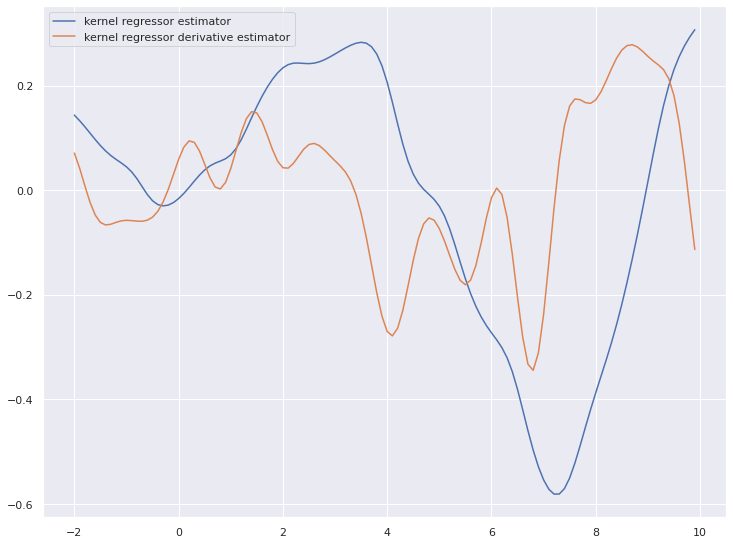

In [91]:
# plot of first derivative of nadaraya-watson estimator 
fig = plt.figure()
ax = fig.add_subplot(2, 2, 1)
g = ax.grid(True)
ax.plot(x, y_hat, label='kernel regressor estimator')
ax.plot(x, y_hat_deriv, label = 'kernel regressor derivative estimator')
leg = ax.legend()
plt.tight_layout()
plt.show()

4. Try your best to fix the boundary issues. 

    Approach to Problem 4: 

    - Identify the data points near upper bound and lower bound
    - Adjust the weight given to those data points

In [93]:
upper_bound = 10
lower_bound = -2

In [96]:
# original kernel regression estimator without boundary correction
n = 200
data, _ , _ = generate_data(n)
xi = data[:, 1]
x = np.arange(-2, 10, .1)
# estimate bandwidth - calculate on the first dataset
h_cv = estimate_bandwidth(data, gaussian_pdf)
print(h_cv)
# estimate f_hat 
estimator = kernel_regression_estimator(data, gaussian_pdf, bandwidth=h_cv)
y_hat = [estimator(i) for i in x]

0.29


In [141]:
# =========================================================
# Kernel Regression Estimator with Boundary Correction    |
# =========================================================
def kernel_regression_estimator_boundary(data, kernel_func, bandwidth, upper_bound, lower_bound):
    """ Generate kernel regression estimator over data."""
    X = data[:, 1]
    Y = data[:, 0]
    kernels = dict()
    n = len(X)
    for d in X:
        kernels[d] = kernel_func(d, bandwidth)
    def evaluate(x):
        """Evaluate `x` using kernels above."""
        resp = list()
        weight = list()
        for d in X:
            resp.append(kernels[d](x))
        resp_sum = sum(resp) # denominator
        for i in range(n):
            weight.append(resp[i]/resp_sum)
        result = list()
        for i in range(n):
            # check if x_i is near boundaries
            p_ub = (upper_bound - X[i]) / bandwidth 
            p_lb = (X[i] - lower_bound) / bandwidth
            if p_ub < 1:
                a = 1.1
                result.append(weight[i]/a * Y[i])
            elif p_lb < 1:
                a = 0.9
                result.append(weight[i]/a * Y[i])
            else:
                result.append(weight[i]*Y[i])
        return sum(result)
    return (evaluate)


In [142]:
# kernel regression estimator with boundary correction 
# estimate f_hat 
estimator_bc = kernel_regression_estimator_boundary(data, gaussian_pdf, h_cv, upper_bound, lower_bound)
y_hat_bc = [estimator_bc(i) for i in x]

In [143]:
_, true_y, _ = true_function()

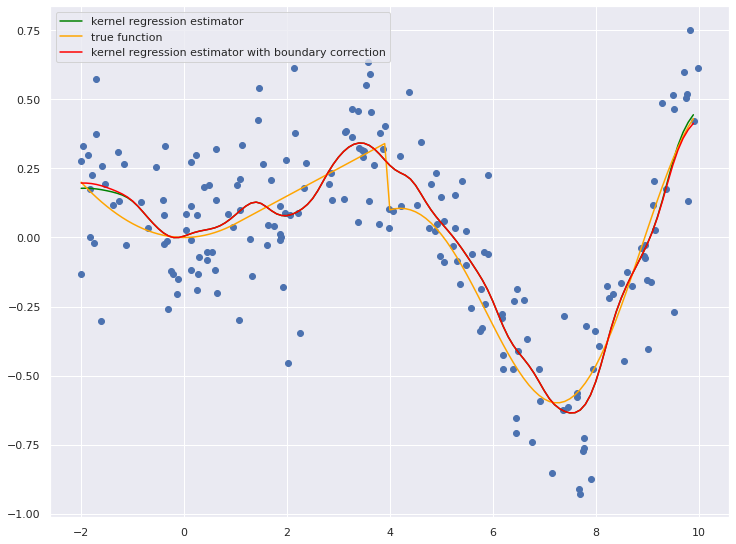

In [144]:
# plot of mean, bottom 2.5 percent, upper 2.5 percent, and true function 
fig = plt.figure()
ax = fig.add_subplot(2, 2, 1)
g = ax.grid(True)
ax.plot(x, y_hat, color='green', label='kernel regression estimator')
ax.plot(x, true_y, color='orange', label='true function')
ax.plot(x, y_hat_bc, color='red', label='kernel regression estimator with boundary correction')
ax.scatter(data[:, 1], data[:, 0])
leg = ax.legend()
plt.tight_layout()
plt.show()